# Le cas crue


### Références

* http://openturns.github.io/openturns/1.12/examples/flood_model.html
* http://openturns.github.io/openturns/1.12/theory/reliability_sensitivity/monte_carlo_simulation.html

### Objectifs
* Protéger une installation industrielle contre une crue (de cote H) en déterminant la hauteur de la digue (Zd)
* Quels enjeux / critères décisionnels ? Protection réglementaire : pas de débordement pour un risque réglementé

### Entrées
On considère les quatre variables suivantes : 
* Q : le débit de la rivière ($m^3/s$)
* Ks : le coefficient de Strickler ($m^{1/3}/s$)
* Zv : la côte du fond de la rivière en aval (m)
* Zm : la côte du fond de la rivière en amont (m)

### Notes : 
* Quand Ks augmente, le fond de la rivière oppose moins de frottement à l'écoulement de l'eau.
* On fait l'hypothèse que les variables sont statistiquement indépendantes.

### Paramètres

On considère les valeurs suivantes des paramètres :
* la hauteur de la digue : Hd = 3 (m),
* la côte de la berge Zb = 55.5 (m),
* la longueur du tronçon de rivière L = 5000 (m),
* la largeur de la rivière B = 300 (m).

### Sortie

La côte de la digue est :
$$
Z_d = Z_b + H_d
$$
La pente de la rivière est supposée proche de zéro, ce qui implique :
$$
\alpha = \frac{Z_m - Z_v}{L},
$$
si $Z_m \geq Z_v$. 
La hauteur de l'eau est modélisée par :
$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$
pour tous $K_s, Q>0$.
La côte de la crue est donc :
$$
Z_c = H + Z_v
$$
La surverse est définie par :
$$
S = Z_c - Z_d
$$

<img src="river_section_adjusted_light.png" width="400" />

### Lois de distribution

On fait l'hypothèse que les variables d'entrée sont *indépendantes* et suivent les lois suivantes.

|Variable|Distribution|
| ------------- |-------------|
|Q|Gumbel(scale=558, mode=1013)>0|
|Ks|Normal(mean=30, standard deviation=7.5)>0|
|Zv|Uniform(min=49, max=51)|
|Zm|Uniform(min=54, max=56)|

### Quantité d'intérêt

On veut estimer la probabilité que la hauteur de la crue $Z_c$ soit plus grande qu'une hauteur de digue $Z_d$ donnée. En d'autres termes, on souhaite estimer la probabilité :
$$
P_f = P(S>0)
$$


## Script Python

On commmence par importer les modules Python nécessaires.


In [1]:
from openturns.viewer import View
import openturns as ot
from math import sqrt

Puis on définit la fonction à travers laquelle on souhaite propager les incertitudes avec l'opérateur `def`.


In [2]:
def functionCrue(X) :
    Hd = 3.0
    Zb = 55.5
    L = 5.0e3
    B = 300.0
    Zd = Zb + Hd
    Q, Ks, Zv, Zm = X
    alpha = (Zm - Zv)/L
    H = (Q/(Ks*B*sqrt(alpha)))**(3.0/5.0)
    Zc = H + Zv
    S = Zc - Zd
    return [S]

Il faut ensuite convertir cette fonction Python en une fonction qu'OpenTURNS peut comprendre avec la classe `PythonFunction`. On équipe cette fonction d'un système d'enregistrement des entrées et des sorties avec la classe `MemoizeFunction` : on reviendra sur ce sujet par la suite. 

In [3]:
f = ot.PythonFunction(4, 1, functionCrue) 
f = ot.MemoizeFunction(f)

Puis on créé les lois de distribution associées à chaque variable d'entrée aléatoire. 
* La variable Q est associée à la loi de distribution de Gumbel. Cette loi peut être paramétrée de plusieurs manières différentes. Ici, les paramètres donnés sont les paramètres d'échelle et de mode, ce qui correspond à la classe `GumbelAB`. 
* Les variables Q et Ks doivent rester positives (une valeur négative de ces variables n'est pas compatible avec le modèle physique). C'est pour cette raison que l'on utilise la classe `TruncatedDistribution`. 

In [4]:
myParam = ot.GumbelAB(1013., 558.)
Q = ot.ParametrizedDistribution(myParam)
otLOW = ot.TruncatedDistribution.LOWER
Q = ot.TruncatedDistribution(Q, 0, otLOW)
Ks = ot.Normal(30.0, 7.5)
Ks = ot.TruncatedDistribution(Ks, 0, otLOW)
Zv = ot.Uniform(49.0, 51.0)
Zm = ot.Uniform(54.0, 56.0)

On complète les variables aléatoires avec des descriptions : elles seront utilisées pour produire les graphiques.

In [5]:
Q.setDescription(["$Q (m^3/s)$"])
Ks.setDescription(["$Ks (m^{1/3})/s)$"])
Zv.setDescription(["Zv (m)"])
Zm.setDescription(["Zm (m)"])

Observons les densités de probabilités des variables. La méthode `drawPDF` produit un graphique qui représente la densité de probabilité de la variable.

Lorsqu'on regarde de près le graphique associé à la loi de probabilité de Q, on observe un petit décrochement de la densité pour Q=0 : il est dû à la troncature de la loi. 

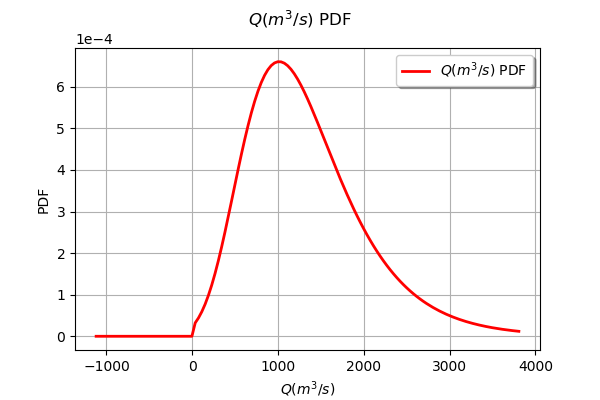

In [6]:
Q.drawPDF()

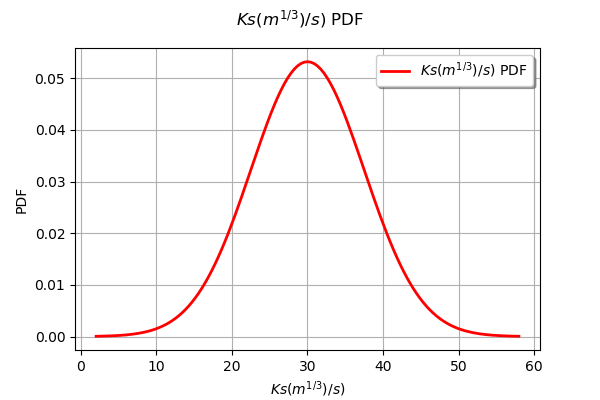

In [7]:
Ks.drawPDF()

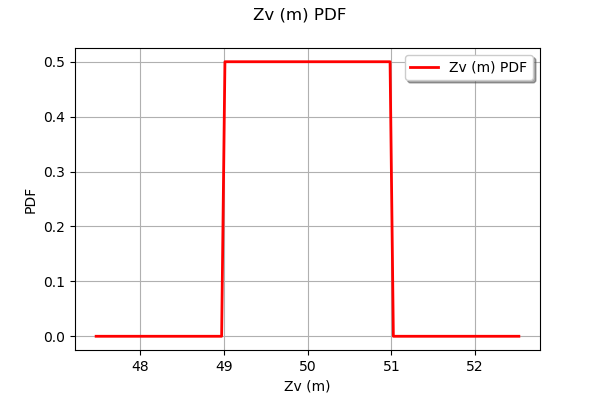

In [8]:
Zv.drawPDF()

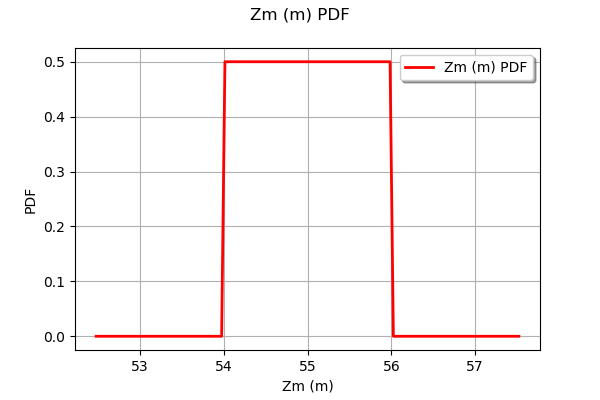

In [9]:
Zm.drawPDF()

On créé ensuite le vecteur aléatoire d'entrée `inputvector` : par défaut la copule est indépendante. 
Puis on créé le vecteur aléatoire de sortie `S` ainsi que l'évènement `eventF` dont on souhaite estimer la probabilité.

In [10]:
inputDist = ot.ComposedDistribution([Q, Ks, Zv, Zm])
inputRV = ot.RandomVector(inputDist)
S = ot.RandomVector(f, inputRV)
eventF = ot.Event(S, ot.GreaterOrEqual(), 0)

On peut tracer un échantillon de 500 points en entrée du modèle avec la classe `Pairs`. 

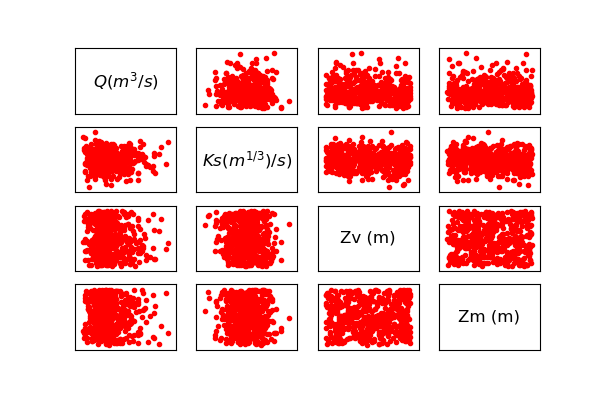

In [11]:
sample = inputRV.getSample(500)
myPairs = ot.Pairs(sample, "N=500", sample.getDescription(), "red", "bullet")
myPairs

Pour estimer la probabilité de dépassement de seuil, on utilise la classe `ProbabilitySimulationAlgorithm`. 

La probabilité exacte $P_f$ est approchée par 
$$
\hat{P}_f = \frac{1}{N} \sum_{i=1}^N {\bf 1}_{\{g({\bf x}_i)<0\}}
$$
où $N$ est le nombre d'appel au code $g$ et ${\bf x}_i$ est la ième réalisation du vecteur aléatoire ${\bf X}$.

Le coefficient de variation est 
$$
CV  = \sqrt{\frac{1-\hat{P}_f}{N \hat{P}_f}}.
$$

Puisque $\hat{P}_f$ est proche de zéro, on a :
$$
CV \approx \sqrt{\frac{1}{N \hat{P}_f}}
$$

L'algorithme s'arrête 
* lorsque le nombre maximum de boucles externes N devient supérieur au seuil, 
* ou lorsque le coefficient de variation devient inférieur au seuil.

On configure le nombre de boucles externes de telle sorte que la précision requise sur le coefficient de variation (par défaut CV = 0.1) soit atteinte. Sinon, puisque la probabilité recherchée est faible, la valeur par défaut du paramètre `MaximumOuterSampling` égale à 1000 serait atteinte en premier, sans garantie de précision sur le coefficient de variation. 

In [12]:
algoProb = ot.ProbabilitySimulationAlgorithm(eventF)
algoProb.setMaximumOuterSampling(1000000)
algoProb.run()

Il n'y a plus qu'à exploiter les résultats. Pour cela, on utilise la méthode `getResult` qui retourne un objet contenant les résultats de la simulation. 

In [13]:
resultAlgo = algoProb.getResult()
neval = f.getEvaluationCallsNumber()
print("Number of function calls = %d" %(neval))
pf = resultAlgo.getProbabilityEstimate()
print("Failure Probability = %e" % (pf))
level = 0.95
c95 = resultAlgo.getConfidenceLength(level)
pmin=pf-0.5*c95
pmax=pf+0.5*c95
print("%.1f %% confidence interval :[%e,%e] " % (level*100,pmin,pmax))

Number of function calls = 167801
Failure Probability = 5.959440e-04
95.0 % confidence interval :[4.791759e-04,7.127121e-04] 


Puisque le nombre d'appels à la fonction est inférieur à 1000000, cela implique que le critère d'arrêt sur le coefficient de variation a été atteint. 
On observe que la probabilité d'observer une surverse positive est dans l'intervalle $[6\times 10^{-4},9\times 10^{-4}]$, avec un chiffre significatif environ : cela est confirmé par la largeur de l'intervalle de confiance à 95%. 

On trace ensuite l'histogramme des surverses. Pour cela, on utilise la méthode `getOutputHistory` de la fonction `f`, qui est disponible grâce à la classe `Memoize` utilisée précédemment.

On modifie la borne supérieure de l'axe des abscisses. Sinon, la surverse la plus grande est utilisée (proche de 70). 
Les valeurs de surverses plus grandes que 5 (m) sont associées à une densité très faible, ce qui mène à un histogramme très déformé. 

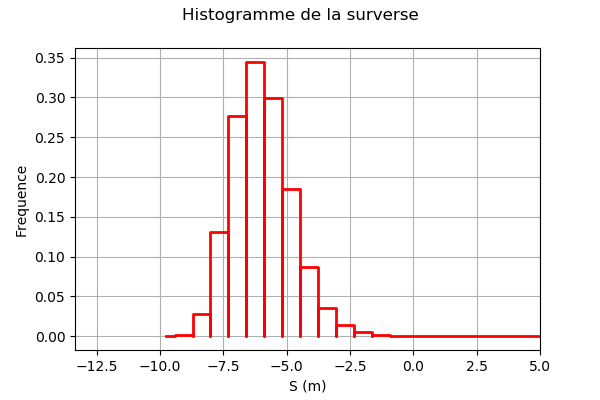

In [14]:
outComputedPoints = f.getOutputHistory()
histoGraph = ot.VisualTest.DrawHistogram(outComputedPoints,100)
histoGraph.setTitle("Histogramme de la surverse")
histoGraph.setXTitle("S (m)")
histoGraph.setYTitle("Frequence")
bb = histoGraph.getBoundingBox()
bb_upper = bb.getUpperBound()
bb_upper[0] = 5
bb.setUpperBound(bb_upper)
histoGraph.setBoundingBox(bb)
histoGraph.setLegends([""])
histoGraph

On observe que la surverse moyenne est proche de -6 mètres. Cela explique pourquoi la probabilité d'observer une surverse positive est faible. 

## Exercices

### Exercice 1
Nous avons utilisé 1013 comme mode de la loi de Gumbel. Que se passe-t-il lorsqu'on change ce paramètre et qu'on utilise 1500 ?
* Comment évolue la distribution des débits Q ?
* Comment évolue la probabilité ? Pourquoi ?

### Exercice 2
Nous avons utilisé une hauteur de digue $H_d$ égale à 3 mètres. Comment évolue la probabilité lorsqu'on utilise une hauteur de digue égale à 8 mètres ? Pourquoi ?

### Exercice 3
Nous avons configuré le nombre maximum d'appels à la fonction G avec l'instruction 
```
algoProb.setMaximumOuterSampling(1000000)
```
Que se passe-t-il si on n'utilise pas cette instruction ? Pour cela, commentez la ligne correspondante et exécuter à nouveau l'étude.

### Exercice 4
Quelle méthode de l'objet `algoProb` doit-on configurer pour obtenir une estimation plus précise de la probabilité $P_f$ ? Quelle valeur numérique utiliser ? Quel impact peut-on prévoir sur le nombre d'évaluations de la fonction G ?

### Exercice 5
Nous avons utilisé une densité de probabilité tronquée pour la variable Q. 
* Que-se passe-t-il si on ne tronque pas cette variable ? 
* Pourquoi ?

### Exercice 6

Avec les paramètres que nous avons utilisé pour la simulation de Monte-Carlo, l'ordre de grandeur de la probabilité est bien estimée, mais la probabilité elle-même n'est pas très précisément estimée. Si on souhaitait améliorer la précision d'estimation, que faudrait-il faire ?

## Solutions

### Solution de l'exercice 1

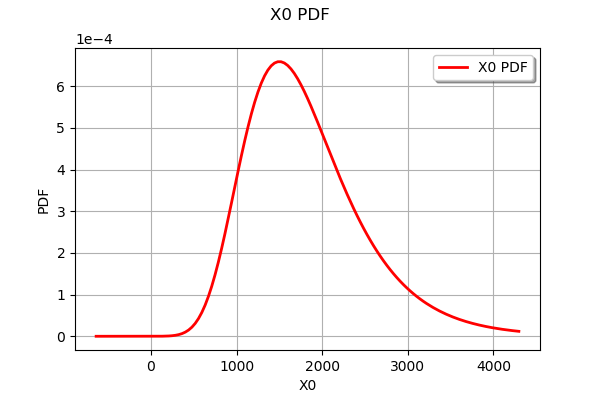

In [15]:
myParam = ot.GumbelAB(1500., 558.)
Q = ot.ParametrizedDistribution(myParam)
otLOW = ot.TruncatedDistribution.LOWER
Q = ot.TruncatedDistribution(Q, 0, otLOW)
Q.drawPDF()

On observe que le mode de la distribution, c'est à dire la valeur de Q pour laquelle la densité est maximale, est, en effet, égal à 1500 au lieu de 1013 auparavant. De manière générale, les débits associés à cette nouvelle loi sont plus grands. 
Calculons maintenant la probabilité associée à cette nouvelle distribution de Q.

In [16]:
inputvector = ot.ComposedDistribution([Q, Ks, Zv, Zm])
inputRV = ot.RandomVector(inputvector)
S = ot.RandomVector(f, inputRV)
eventF = ot.Event(S, ot.GreaterOrEqual(), 0)
algoProb = ot.ProbabilitySimulationAlgorithm(eventF)
algoProb.setMaximumOuterSampling(100000)
algoProb.run()
resultAlgo = algoProb.getResult()
neval = f.getEvaluationCallsNumber()
print("Number of function calls = %d" %(neval))
pf = resultAlgo.getProbabilityEstimate()
print("Failure Probability = %e" % (pf))
level = 0.95
c95 = resultAlgo.getConfidenceLength(level)
pmin=pf-0.5*c95
pmax=pf+0.5*c95
print("%.1f %% confidence interval :[%e,%e] " % (level*100,pmin,pmax))

Number of function calls = 264289
Failure Probability = 1.036398e-03
95.0 % confidence interval :[8.333733e-04,1.239423e-03] 


On observe que la probabilité est dans l'intervalle $[8\times 10^{-4},12\times 10^{-4}]$, ce qui est supérieur à la probabilité précédente (la probabilité dans le scénario précédent est proche de $6 \times 10^{-4}$). En effet, en augmentant les débits, les hauteurs d'eau sont plus elevées. En conséquence, la probabilité d'être supérieur au seuil de hauteur est également plus grande. 

| Loi de Q | $P(S>0)$ |
|---|---|
| GumbelAB(1013., 558.) | $[6\times 10^{-4},9\times 10^{-4}]$ |
| GumbelAB(1500., 558.) | $[8\times 10^{-4},12\times 10^{-4}]$ |


### Solution de l'exercice 2

On souhaite estimer la probabilité lorsqu'on utilise Hd = 8. Or la variable Hd est "codée en dur" dans le corps de la fonction "functionCrue". Pour obtenir la probabilité, nous pourrions changer le code en mettant à jour la hauteur de la digue, puis exécuter à nouveau le reste de la simulation.

Pour répondre à la question, on propose plutôt de créer une fonction paramétrique dans laquelle on pourra facilement changer la valeur de Hd.

In [17]:
def functionCrue8var(X) :
    Q, Ks, Zv, Zm, Hd, Zb, L, B = X
    Zd = Zb + Hd
    alpha = (Zm - Zv)/L
    H = (Q/(Ks*B*sqrt(alpha)))**(3.0/5.0)
    Zc = H + Zv
    S = Zc - Zd
    return [S]

f8v = ot.PythonFunction(8, 1, functionCrue8var) 
f8v.setDescription(["Q", "Ks", "Zv", "Zm", "Hd", "Zb", "L", "B", "S"])
f8v = ot.MemoizeFunction(f8v)
print(f8v)

Hd = 8.0
Zb = 55.5
L = 5.0e3
B = 300.0
g = ot.ParametricFunction(f8v, [4, 5, 6, 7], [Hd, Zb, L, B])
print(g)

class=PythonEvaluation name=OpenTURNSPythonFunction
ParametricEvaluation(class=PythonEvaluation name=OpenTURNSPythonFunction, parameters positions=[4,5,6,7], parameters=[Hd : 8, Zb : 55.5, L : 5000, B : 300], input positions=[0,1,2,3])


In [ ]:
# Modèle probabiliste
myParam = ot.GumbelAB(1013., 558.)
Q = ot.ParametrizedDistribution(myParam)
otLOW = ot.TruncatedDistribution.LOWER
Q = ot.TruncatedDistribution(Q, 0, otLOW)
Ks = ot.Normal(30.0, 7.5)
Ks = ot.TruncatedDistribution(Ks, 0, otLOW)
Zv = ot.Uniform(49.0, 51.0)
Zm = ot.Uniform(54.0, 56.0)

# Vecteur aléatoire
inputDist = ot.ComposedDistribution([Q, Ks, Zv, Zm])
inputRV = ot.RandomVector(inputDist)
S = ot.RandomVector(g, inputRV) # On utilise g au lieu de f
eventF = ot.Event(S, ot.GreaterOrEqual(), 0)

# Estimation de la probabilité
algoProb = ot.ProbabilitySimulationAlgorithm(eventF)
algoProb.setMaximumOuterSampling(1000000)
algoProb.run()
resultAlgo = algoProb.getResult()
neval = f.getEvaluationCallsNumber()
print("Number of function calls = %d" %(neval))
pf = resultAlgo.getProbabilityEstimate()
print("Failure Probability = %e" % (pf))
level = 0.95
c95 = resultAlgo.getConfidenceLength(level)
pmin=pf-0.5*c95
pmax=pf+0.5*c95
print("%.1f %% confidence interval :[%e,%e] " % (level*100,pmin,pmax))

On observe désormais une probabilité dans l'intervalle $[5 \times 10^{-5},9 \times 10^{-5}]$. C'est une probabilité beaucoup plus faible que dans la situation précédente. En effet, cela décale la densité de probabilité des surverses $S$ de 5 mètres vers la gauche, ce qui diminue la probabilité de dépasser le seuil zéro.

| Hauteur de digue (m) | $P(S>0)$ |
|---|---|
| 3 | $[6\times 10^{-4},9\times 10^{-4}]$ |
| 8 | $[5 \times 10^{-5},9 \times 10^{-5}]$ |


### Solution de l'exercice 6

Pour améliorer la précision d'estimation de la probabilité, on peut 
* diminuer le critère portant sur le coefficient de variation maximum (ce qui augmente le nombre d'évaluations de la fonction)
* changer d'algorithme (pour améliorer la performance).